In [1]:
import os
import ndspy.rom
import ndspy.narc

os.chdir("/workspace")

In [2]:
from PIL import Image
import struct

def make_palette(data: bytes):
    # Skip first 40 bytes
    # Then read 16 ushorts
    # Each ushort is a 5-5-5 BGR color. 
    # The code converts them into 24-bit RGB by shifting and multiplying by 8.
    offset = 40
    raw = data[offset:offset+16*2]
    arr = struct.unpack('<16H', raw)

    print(len(arr))
    
    palette = []
    for val in arr:
        r = ((val >> 0) & 0x1F) << 3
        g = ((val >> 5) & 0x1F) << 3
        b = ((val >> 10) & 0x1F) << 3
        palette.extend((r, g, b))

    return palette
    

def make_image(data: bytes, dpcheck: bool, palette):
    # Skip first 48 bytes, then read 3200 ushorts.
    offset = 48
    raw = data[offset:offset+3200*2]
    arr = list(struct.unpack('<3200H', raw))

    # Perform XOR transformation
    if not dpcheck:
        num = arr[0]
        for j in range(3200):
            arr[j] ^= (num & 0xFFFF)
            num = (num * 1103515245 + 24691) & 0xFFFFFFFF
    else:
        num = arr[3199]
        for j in range(3199, -1, -1):
            arr[j] ^= (num & 0xFFFF)
            num = (num * 1103515245 + 24691) & 0xFFFFFFFF

    # Decompose each ushort into 4 pixels (4 nibbles)
    # Each pixel: 4 bits -> convert to a byte (0-15)
    # array3 length = 3200*4 = 12800
    # image size: 160 x 80 = 12800 pixels total
    img_data = bytearray(12800)
    for k in range(3200):
        val = arr[k]
        img_data[k*4 + 0] = (val & 0xF)
        img_data[k*4 + 1] = ((val >> 4) & 0xF)
        img_data[k*4 + 2] = ((val >> 8) & 0xF)
        img_data[k*4 + 3] = ((val >> 12) & 0xF)

    # Create an 8bpp indexed image
    img = Image.frombytes('P', (160, 80), bytes(img_data))

    palette.extend([0]*(768 - 48))

    img.putpalette(palette)

    return img


In [10]:
def image_by_dex(dex, sprite=3, shiny=False):
    base_index = dex * 6
    sprite_index = base_index + sprite
    palette_index = base_index + 4
    shiny_palette_index = base_index + 5

    if shiny:
        palette = make_palette(narc.files[shiny_palette_index])
    else:
        palette = make_palette(narc.files[palette_index])

    image = make_image(narc.files[sprite_index], False, palette)

    return image


In [4]:
# load the narc data for the pokemon sprites
rom = ndspy.rom.NintendoDSRom.fromFile("Pokemon - HeartGold Version (USA).nds")
narcData = rom.getFileByName("a/0/0/4")
narc = ndspy.narc.NARC(narcData)

In [25]:
# load the narc data for the overworld sprites
rom = ndspy.rom.NintendoDSRom.fromFile("Pokemon - HeartGold Version (USA).nds")
narcData = rom.getFileByName("a/0/8/1")

# these files are btx files, not ncgr files
overworldNarc = ndspy.narc.NARC(narcData)

16


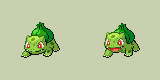

In [42]:
palette = make_palette(palette_bytes)
make_image(sprite_bytes, False, palette)

In [ ]:
image_by_dex(151, 3, True)

NameError: name 'image_by_dex' is not defined